In [2]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level
import math

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact_manual

plotting_backend = "plotly-static"

In [9]:
df=pd.read_csv("Load_in_Great_Britain.csv")
df.shape

(6395, 2)

In [10]:
df.columns = ['ds', 'y']

In [11]:
fig = px.line(df, x=df["ds"], y=df["y"])
fig.show()

## Neural Prophet

In [12]:
quantiles = [0.015, 0.985]

params = {
    "n_lags": 24,
    "n_forecasts": 7,
    "n_changepoints": 20,
    "learning_rate": 0.01,
    "ar_layers": [32, 16, 16, 32],
    "epochs": 70,
    "batch_size": 64,
    "quantiles": quantiles,
}


m = NeuralProphet(**params)
m.set_plotting_backend(plotting_backend)
set_log_level("ERROR")

In [13]:
df_train, df_test = m.split_df(df, valid_p=0.1, local_split=True)
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (5916, 2)
Test shape: (684, 2)


In [14]:
metrics_fit = m.fit(df_train, freq="D", metrics=True)

Training: 0it [00:00, ?it/s]

In [15]:
forecast = m.predict(df_test)

Predicting: 92it [00:00, ?it/s]

In [16]:
fig = go.Figure()
fig.update_layout(title="Neural Prophet with GB Load values")
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real Data'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat1'], mode='lines', name='Forecast Data'))
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Training'))
fig.show()

In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(f'R2 Score : {r2_score(forecast.iloc[25:]["y"],forecast.iloc[25:]["yhat1"])}')
print(f'RMSE : {math.sqrt(mean_squared_error(forecast.iloc[25:]["y"],forecast.iloc[25:]["yhat1"]))}')
print(f'MAE : {mean_absolute_error(forecast.iloc[25:]["y"],forecast.iloc[25:]["yhat1"])}')

R2 Score : 0.9750144349172014
RMSE : 26.249500757965563
MAE : 20.243562653209466


## LSTM

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator
 
n_input = 24
n_features = 1
generator = TimeseriesGenerator(df_train['y'],
                                df_train['y'],
                                length=n_input,
                                batch_size=32)
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[ 638.5  578.   565.5  540.   500.5  479.5  484.   525.5  579.5  632.
  690.   765.5  838.5  919.5  962.   951.5  985.  1018.5 1074.5  993.
  903.   848.5  797.5  742.   578.   565.5  540.   500.5  479.5  484.
  525.5  579.5  632.   690.   765.5  838.5  919.5  962.   951.5  985.
 1018.5 1074.5  993.   903.   848.5  797.5  742.   672.5  565.5  540.
  500.5  479.5  484.   525.5  579.5  632.   690.   765.5  838.5  919.5
  962.   951.5  985.  1018.5 1074.5  993.   903.   848.5  797.5  742.
  672.5  597.5  540.   500.5  479.5  484.   525.5  579.5  632.   690.
  765.5  838.5  919.5  962.   951.5  985.  1018.5 1074.5  993.   903.
  848.5  797.5  742.   672.5  597.5  561.5  500.5  479.5  484.   525.5
  579.5  632.   690.   765.5  838.5  919.5  962.   951.5  985.  1018.5
 1074.5  993.   903.   848.5  797.5  742.   672.5  597.5  561.5  540.5
  479.5  484.   525.5  579.5  632.   690.   765.5  838.5  919.5  962.
  951.5  985.  1018.5 1074.5  993.   903.   848.5  797.5  742.   672

In [20]:
# define model
model = Sequential()
model.add(LSTM(75, activation='relu',
               input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()
history = model.fit(generator, epochs=60)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 75)                23100     
                                                                 
 dense (Dense)               (None, 1)                 76        
                                                                 
Total params: 23176 (90.53 KB)
Trainable params: 23176 (90.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/60
185/185 [==============================] - 8s 21ms/step - loss: 320.8295
Epoch 2/60
185/185 [==============================] - 6s 32ms/step - loss: 287.0239
Epoch 3/60
185/185 [==============================] - 6s 30ms/step - loss: 139.7670
Epoch 4/60
185/185 [==============================] - 5s 27ms/step - loss: 135.1837
Epoch 5/60
185/185 [==============================] - 4s 21ms/step - loss: 122.1

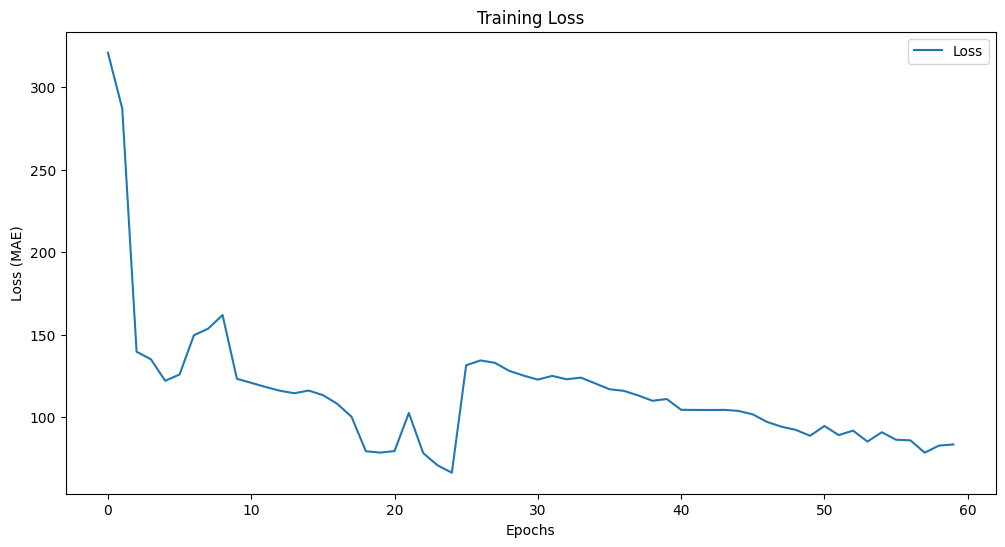

In [21]:
import matplotlib.pyplot as plt
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [22]:
n_input = 24
n_features = 1
test_generator = TimeseriesGenerator(df['y'],
                                df['y'],
                                length=n_input,
                                batch_size=32)
out=model.predict(test_generator)

200/200 [==============================] - 2s 9ms/step


In [23]:
out_test=out[df.shape[0]-df_test.shape[0]-n_input:]
out_test.reshape(-1).shape

(684,)

In [ ]:
fig = go.Figure()
fig.update_layout(title="LSTM with GB ")
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real Data'))
fig.add_trace(go.Scatter(x=df_test['ds'], y=out_test.reshape(-1), mode='lines', name='Forecast Data'))
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Training'))
fig.show()